# Doc Reader

In [1]:
import os
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
import pytesseract
from PIL import Image
import easyocr
from wordcloud import WordCloud
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import ParameterGrid
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from unidecode import unidecode
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'  

ORC con PytTesseract

In [3]:
image = Image.open('data\scientific_publication\doc_000240.png')
text = pytesseract.image_to_string(image)

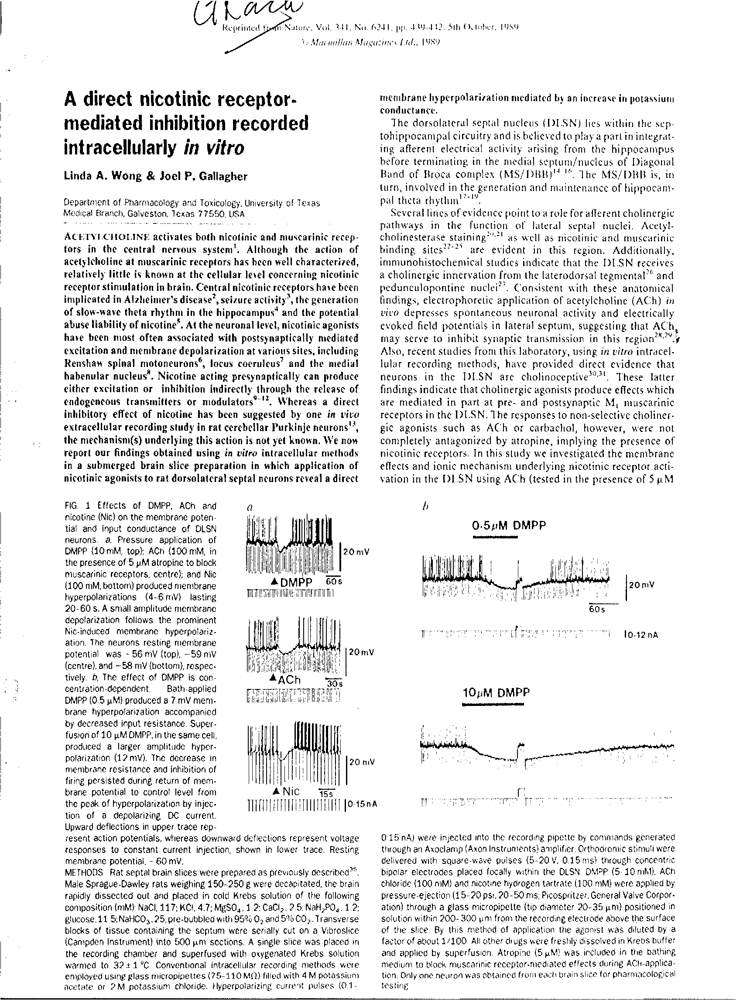

In [4]:
image

In [5]:
print(text)

Lary

A ripen

A direct nicotinic receptor-
mediated inhibition recorded
intracellularly in vitro

Linda A. Wong & Joe! P. Gallagher

Department of Parmaceiogy and Toco. Unversiy of Texas
‘Mosel fereh Gveston Texas 77580 VA

ACEIVECHOLINE activates both nicotinic and muscatn
tors in the central nervous system’. Although the a
acetylcholine at rivseainic receptors has beca wel ch
‘relatively little is hoown atthe cellular level coaceraing nicotinic
receptor stinifaton in brain, Cental nicotinic receptors have been
implicated in Alzheimer's disease, seizure actisiy” the generation
‘of slonenane theta rhythm inthe hippocampus! and the potetil
abuse lability of nicotine’, At the neuronal lve, nicotinic agonists
hhave been most often associated with postsynaptically mediated
‘excitation and membrane depolarization at arious si

Renshaw spinal mn

hhabenulae nucleus

icatine acting presynaptically can produce
cither excitation or inhibition Indiectly through the release of
‘endogencous trans

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Max\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Max\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
stopwords_list = stopwords.words("english")

In [8]:
def preprocess_data(text):
    text = text.lower()
    text = text.replace("\n"," ").replace("\t"," ")
    text = re.sub("\s+"," ",text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    
    # tokens
    tokens = word_tokenize(text)
    
    data = [i for i in tokens if i not in punctuation]
    data = [i for i in data if i not in stopwords_list]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    final_text = []
    for i in data:
        word = lemmatizer.lemmatize(i)
        final_text.append(word)
        
    return " ".join(final_text)


In [9]:
class_labels = {'email':0,'resume':1,'scientific_publication':2}
final_text = []
final_label = []
path = "data/"
file_folder = os.listdir(path)

for label in file_folder:
        label_path = os.path.join(path,label)
        for j in os.listdir(label_path):
            image = Image.open(label_path+"/"+j)
            text = pytesseract.image_to_string(image)
            text_data = preprocess_data(text)
            
            final_text.append(text_data)
            final_label.append(class_labels[label])

text_df = pd.DataFrame()
text_df['text'] = final_text
text_df['label'] = final_label

In [10]:
text_df["text"][1]

'teitelbaum shari thu jul subject july ath meeting saloun thomas ce rodriguez ana tom meeting spoke day melissa jeltera richmond scheduled july th shes going brief u status reduced ignition project date take natalie utlibe wel since itrelates new productmarbore research hari'

In [11]:
text_df['text']

0      moskowitz seth w coggins chris ce bc subject j...
1      teitelbaum shari thu jul subject july ath meet...
2      mary sue sent monday october pm suydam loraine...
3      ovignal massage moor tamara sent monday cider ...
4      per know need add hanover also want add peters...
                             ...                        
160    oteetan amo canvas biol spt p got eo seaok gpy...
161    xcoconjugate journal sb use monoclonal antilig...
162    copyright reprinted biochemistry amer le seiet...
163    revised archces international de pharmacodynam...
164    copyrgi te ameria aasonont inmunlogate product...
Name: text, Length: 165, dtype: object

In [12]:
text = text_df['text']
labels = text_df['label']
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="<OOV>")
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=10, padding='post', truncating='post')
xtrain_pad = np.array(padded_sequences)
ytrain_pad = np.array(labels)

### Rete neurale V1

In [13]:
xtrain, xval, ytrain, yval = train_test_split(xtrain_pad, ytrain_pad, test_size=0.2, random_state=42)

In [14]:
def create_model_v1(optimizer='adam', dropout_rate=0.5):
    model1 = Sequential()
    model1.add(Embedding(input_dim=1000, output_dim=16, input_length=10))
    model1.add(LSTM(64, return_sequences=True))
    model1.add(Dropout(dropout_rate))
    model1.add(LSTM(64))
    model1.add(Dropout(dropout_rate))
    model1.add(Dense(32, activation='relu'))
    model1.add(Dropout(dropout_rate))
    model1.add(Dense(3, activation='sigmoid'))
    model1.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model1

param_grid1 = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.3, 0.5, 0.7],
    'batch_size': [16, 32, 64, 128]
}

results1 = []

# Loop through each set of hyperparameters
for params in ParameterGrid(param_grid1):
    # Set the hyperparameters for the model
    model1 = KerasClassifier(build_fn=create_model_v1, epochs=20, verbose=0)
    model1.set_params(**params)
   
    checkpoint = ModelCheckpoint('best_model_v1.h5', save_best_only=True)

    history1 = model1.fit(xtrain, ytrain, validation_data=(xval, yval), callbacks=[checkpoint])

    results1.append(history1.history['accuracy'])

C:\Users\Max\AppData\Local\Temp\ipykernel_29292\25896129.py:25: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model1 = KerasClassifier(build_fn=create_model_v1, epochs=20, verbose=0)


0.9772727489471436


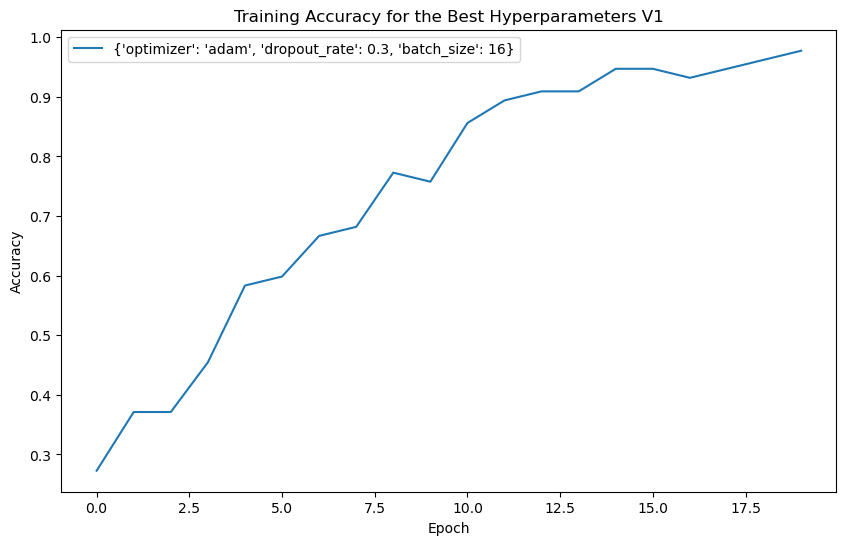

In [15]:
best_index1 = np.argmax(np.mean(results1, axis=1))
print(np.max(results1[best_index1]))

plt.figure(figsize=(10, 6))
plt.plot(results1[best_index1], label=str(ParameterGrid(param_grid1)[best_index1]))

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy for the Best Hyperparameters V1')
plt.legend()
plt.show()

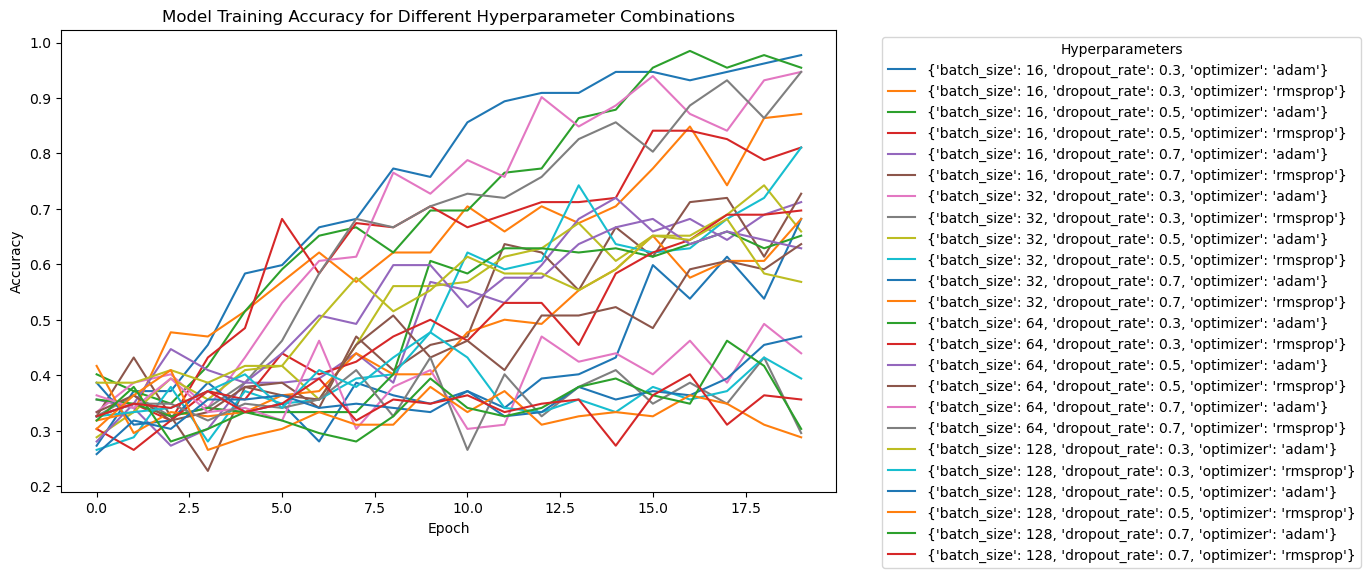

In [16]:
plt.figure(figsize=(10, 6))
for i, params in enumerate(ParameterGrid(param_grid1)):
    plt.plot(results1[i], label=str(params))

plt.title('Model Training Accuracy for Different Hyperparameter Combinations')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title='Hyperparameters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Rete Nerurale V2

In [17]:
def create_model_v2(optimizer='adam', dropout_rate=0.5):
    model2 = Sequential()
    model2.add(Embedding(input_dim=1000, output_dim=32, input_length=10))
    model2.add(LSTM(64, return_sequences=True))
    model2.add(Dropout(dropout_rate))
    model2.add(LSTM(64))
    model2.add(Dropout(dropout_rate))
    model2.add(Dense(64, activation='relu'))  # Aggiunto strato denso
    model2.add(Dropout(dropout_rate))
    model2.add(Dense(3, activation='sigmoid'))
    model2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model2

model2 = KerasClassifier(build_fn=create_model_v2, epochs=20, verbose=0)

param_grid2 = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.3, 0.5, 0.7],
    'batch_size': [16, 32, 64, 128]
}

results2 = []

# Loop through each set of hyperparameters
for params in ParameterGrid(param_grid2):
    # Set the hyperparameters for the model
    model3 = KerasClassifier(build_fn=create_model_v2, epochs=20, verbose=0)
    model2.set_params(**params)
   
    checkpoint = ModelCheckpoint('best_model_v2.h5', save_best_only=True)

    history2 = model2.fit(xtrain, ytrain, validation_data=(xval, yval), callbacks=[checkpoint])

    results2.append(history2.history['accuracy'])

C:\Users\Max\AppData\Local\Temp\ipykernel_29292\3387179325.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model2 = KerasClassifier(build_fn=create_model_v2, epochs=20, verbose=0)
C:\Users\Max\AppData\Local\Temp\ipykernel_29292\3387179325.py:27: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model3 = KerasClassifier(build_fn=create_model_v2, epochs=20, verbose=0)


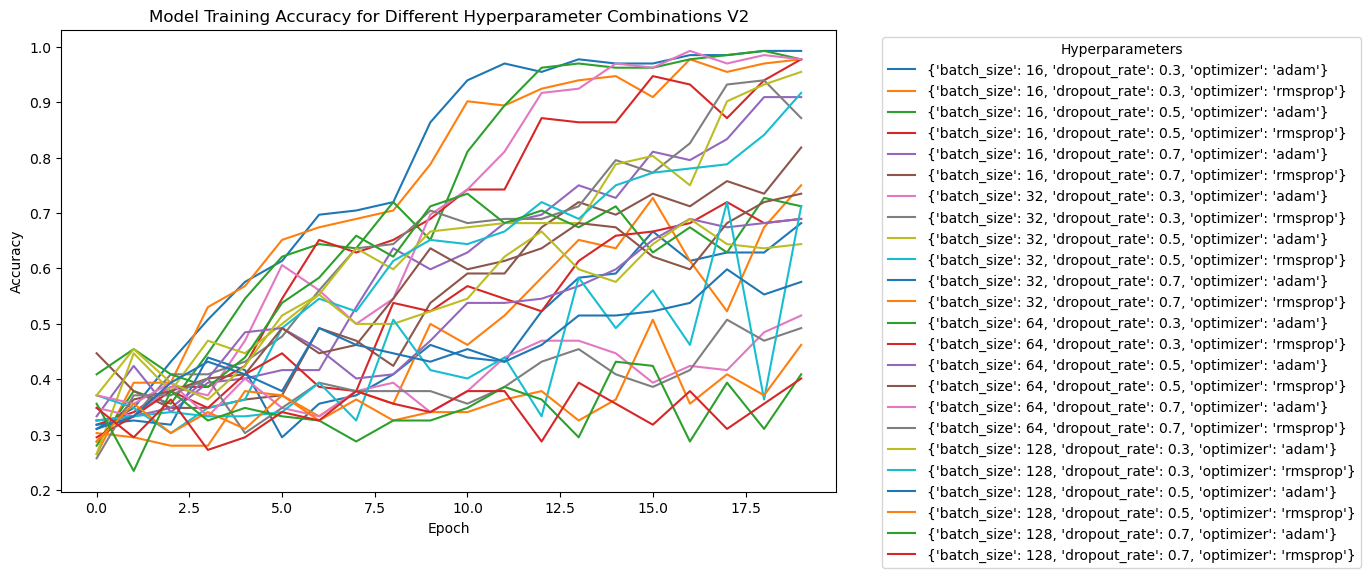

In [18]:
plt.figure(figsize=(10, 6))
for i, params in enumerate(ParameterGrid(param_grid2)):
    plt.plot(results2[i], label=str(params))

plt.title('Model Training Accuracy for Different Hyperparameter Combinations V2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title='Hyperparameters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

0.9924242496490479


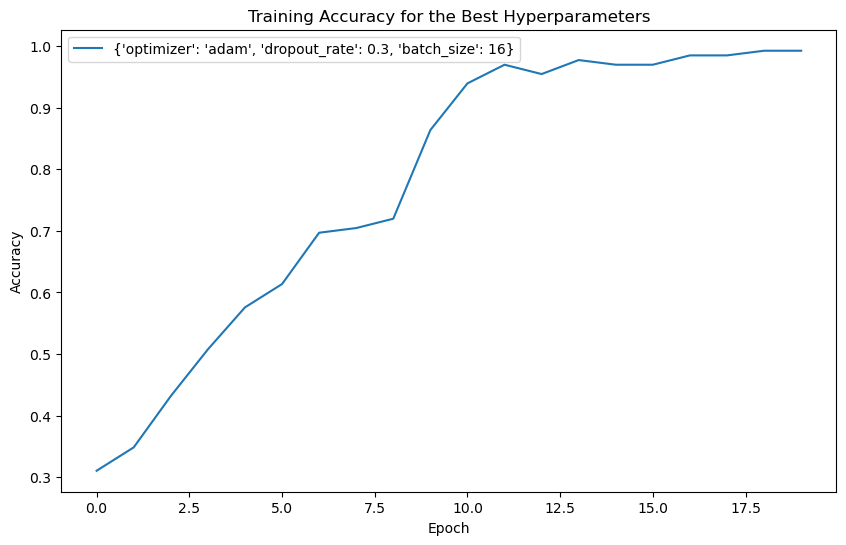

In [19]:

best_index2 = np.argmax(np.mean(results2, axis=1))
print(np.max(results2[best_index2]))
# Plot the results for the best model only
plt.figure(figsize=(10, 6))
plt.plot(results2[best_index2], label=str(ParameterGrid(param_grid2)[best_index2]))

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy for the Best Hyperparameters')
plt.legend()
plt.show()

### Rete Neurale V3

In [20]:

def create_model_v3(optimizer='adam', dropout_rate=0.5):
    model3 = Sequential()
    model3.add(Embedding(input_dim=1000, output_dim=32, input_length=10))
    model3.add(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))) 
    model3.add(Dropout(0.3))  
    model3.add(LSTM(64, kernel_regularizer=l2(0.01)))  
    model3.add(Dropout(0.3))  
    model3.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  
    model3.add(Dropout(dropout_rate))
    model3.add(Dense(3, activation='sigmoid'))
    model3.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model3



param_grid3 = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.3, 0.5, 0.7],
    'batch_size': [16, 32, 64, 128]
}

results3 = []

# Loop through each set of hyperparameters
for params in ParameterGrid(param_grid3):
    # Set the hyperparameters for the model
    model3 = KerasClassifier(build_fn=create_model_v3, epochs=20, verbose=0)
    model3.set_params(**params)
   
    checkpoint = ModelCheckpoint('best_model_v3.h5', save_best_only=True)

    history3 = model3.fit(xtrain, ytrain, validation_data=(xval, yval), callbacks=[checkpoint])

    results3.append(history3.history['accuracy'])

C:\Users\Max\AppData\Local\Temp\ipykernel_29292\467731665.py:27: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model3 = KerasClassifier(build_fn=create_model_v3, epochs=20, verbose=0)


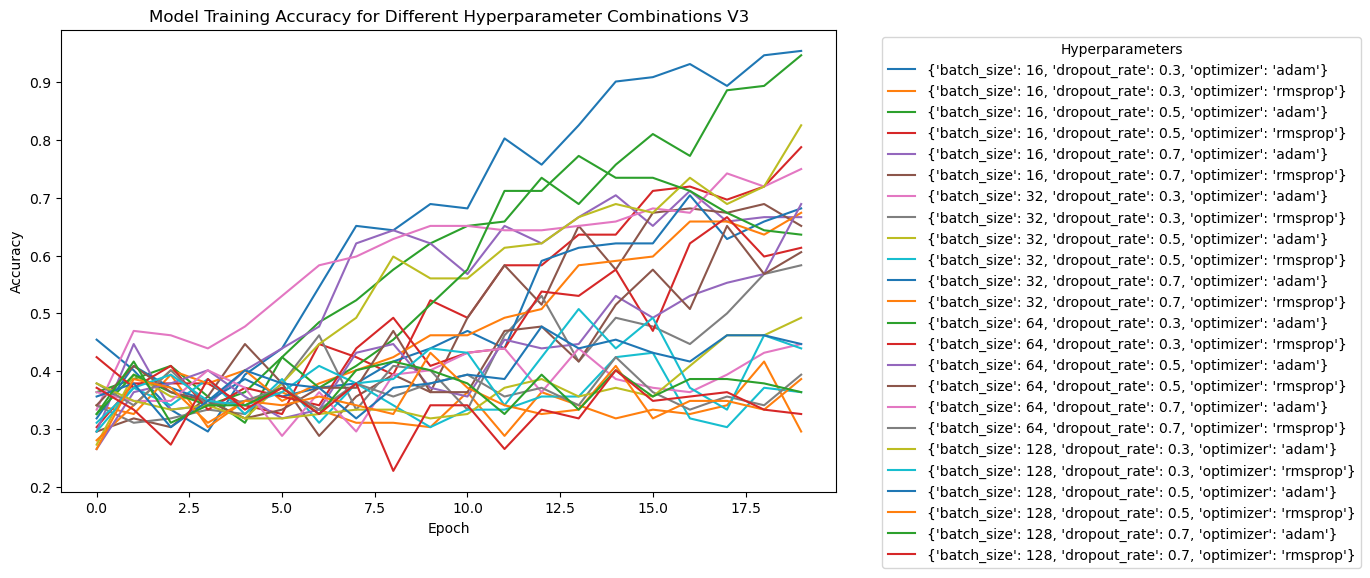

In [21]:
plt.figure(figsize=(10, 6))
for i, params in enumerate(ParameterGrid(param_grid3)):
    plt.plot(results3[i], label=str(params))

plt.title('Model Training Accuracy for Different Hyperparameter Combinations V3')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title='Hyperparameters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

0.9545454382896423


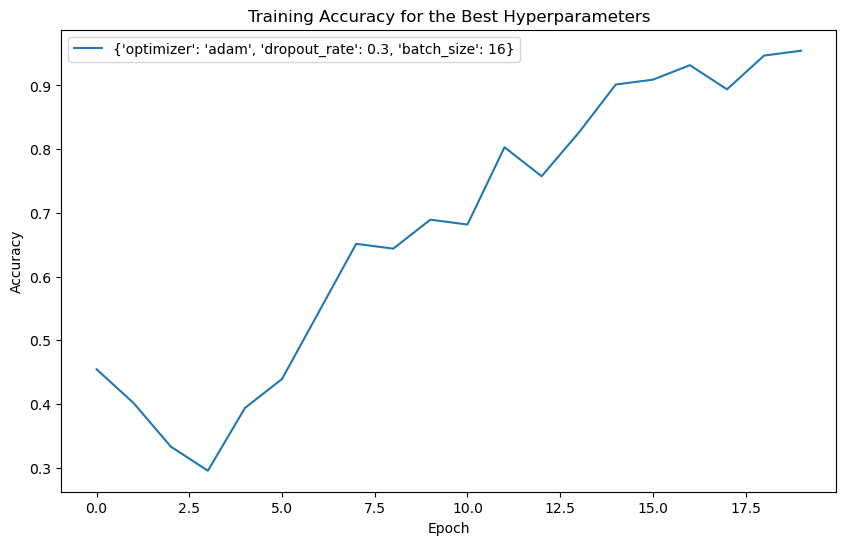

In [22]:

best_index3 = np.argmax(np.mean(results3, axis=1))
print(np.max(results3[best_index3]))
# Plot the results for the best model only
plt.figure(figsize=(10, 6))
plt.plot(results3[best_index3], label=str(ParameterGrid(param_grid3)[best_index3]))

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy for the Best Hyperparameters')
plt.legend()
plt.show()

### Valutazione del modello

In [23]:
new_data = []
# new_data = ["a field that holds immense promise for revolutionizing computation. The authors begin by providing an overview of the fundamental principles of quantum mechanics that underlie quantum computing, emphasizing the unique properties of qubits and their potential to exist in multiple states simultaneously. The publication discusses current state-of-the-art quantum computing technologies, highlighting breakthroughs in qubit stability, error correction, and quantum gate operations. It delves into the ongoing efforts to scale up quantum processors, addressing challenges related to decoherence and maintaining quantum coherence over extended periods. Moreover, the authors discuss practical applications of quantum computing, ranging from optimization problems and cryptography to machine learning and simulations of quantum systems. They explore the potential impact of quantum computers on various industries and emphasize the need for interdisciplinary collaboration to fully unlock their capabilities. The publication also addresses the challenges faced by researchers, including the development of scalable quantum algorithms, error mitigation techniques, and the integration of quantum computers with classical systems. Additionally, the authors provide insights into the future prospects of quantum computing, discussing emerging technologies, quantum communication, and the race towards achieving quantum advantage."]
# new_data = ["Hello Brian I'm am Max your childhood friend, wanna hang out?"]
# new_data = ["Subject: Reunion Invitation\n\n" \
#            "Hi Brian,\n\n" \
#            "I trust this message finds you well. This is Max, your long-lost childhood companion, reaching out to rekindle the old flames of friendship. Fond memories of our shared adventures flooded my mind recently, prompting me to drop you a line.\n\n" \
#            "How about we catch up over a cup of coffee or explore the city, just like the good old days? I'm sure we have countless stories to share and even more laughs to relive.\n\n" \
#            "Let me know if you're up for it. Looking forward to hearing from you and, hopefully, hanging out soon!\n\n" \
#            "Best regards,\nMax"]

image = Image.open("mail_test.png")
test_text = pytesseract.image_to_string(image)
new_data.append(preprocess_data(test_text))


In [24]:
best_model_v1 = load_model('best_model_v1.h5')
best_model_v2 = load_model('best_model_v2.h5')
best_model_v3 = load_model('best_model_v3.h5')
test_sequences = tokenizer.texts_to_sequences(new_data)
new_test_sequences = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=10, padding='post', truncating='post')

# predictions = history2.best_estimator_.model.predict(new_test_sequences)
predictions = best_model_v3.predict(new_test_sequences)

class_labels = {0: 'email', 1: 'resume', 2: 'scientific_publication'}

predicted_labels = [np.argmax(prediction) for prediction in predictions]
predicted_classes = [class_labels[label] for label in predicted_labels if label in class_labels]


for i, text in enumerate(new_data):
    print(f"Testo: {text}")
    if predicted_labels[i] in class_labels:
        print(f"Classe predetta: {predicted_classes[i]}")
    else:
        print(f"Classe predetta: Etichetta mancante ({predicted_labels[i]})")
    print("="*30)


1/1 [==============================] - 1s 922ms/step
Testo: dear gianluca lotti good morning appreciate opportunity within company currently already made arrangement start curricular internship another location available undertake work experience however willing stay touch future opportunity enrich professional experience within company best regard massimo caso
Classe predetta: email
